In [2]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
import pandas as pd
from omegaconf import OmegaConf
from pathlib import Path
from pprint import pprint
# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
# mycode
from repo import REPO
from ml_utilities.output_loader.result_loader import SweepResult, JobResult
from ml_utilities.output_loader import create_job_output_loader
from ml_utilities.output_loader.plot import plot_sweep_summary, plot_data_log_values
from ml_utilities.data.data_utils import show_images
from ml_utilities.data.datasetgenerator import DatasetGenerator
from ml_utilities.torch_models.resnet import Resnet

# 15.10 Resnet on MNIST

In this notebook I want to train a resnet on MNIST. 
Two options:
- Resize MNIST digits to 32x32
- Adapt resnet architecture to 28x28 <TRY THIS!

## Setup Model and Data

In [3]:
data_cfg = """
data:
  dataset: mnist
  dataset_kwargs:
    data_root_path: /system/user/beck/pwbeck/data
  dataset_split:
    train_val_split: 0.9
    # restrict_n_samples_train_task: 10000
  # train_split_transforms:
    # image_transforms:
    # - RandomHorizontalFlip
    # - RandomCrop:
    #     size: 32
    #     padding: 4
    # tensor_transforms: 
    # joint_tensor_transforms: 
    # enable_transforms: True
"""
data_cfg = OmegaConf.create(data_cfg)

In [4]:
datagen = DatasetGenerator(**data_cfg.data)
datagen.generate_dataset()

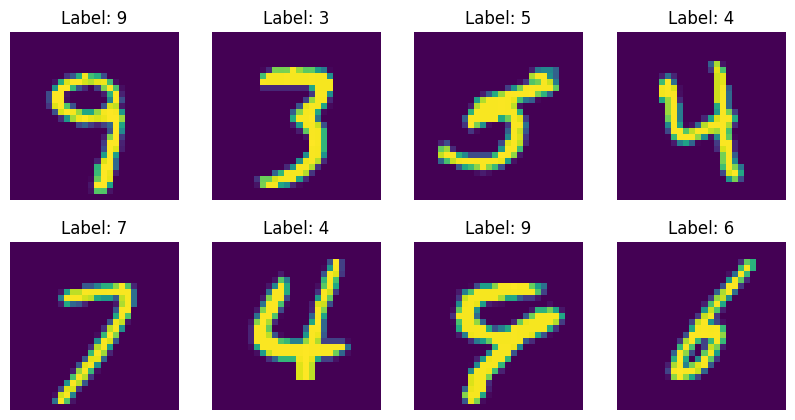

In [5]:
show_images(datagen.train_split, num_images=10, shuffle=False)

In [6]:
datagen.train_split[0][0].shape

torch.Size([1, 28, 28])

In [7]:
model_cfg = """
model:
  name: resnet
  model_kwargs:
    in_channels: 1
    act_fn: relu
    residual_option: B
    input_layer_config:
      kernel_size: 3
      out_channels: 16
      bias: false
      batch_norm: true
      stride: 1
      padding: 1
    resnet_blocks_config:
      - out_channels: 16
        num_residual_blocks: 3
      - out_channels: 32
        num_residual_blocks: 3
      - out_channels: 64
        num_residual_blocks: 3
    linear_output_units:
      - 10
    model_initializer: kaiming_normal
    batchnorm_initializer: uniform
"""
model_cfg = OmegaConf.create(model_cfg)

In [8]:
model = Resnet(**model_cfg.model.model_kwargs)

In [9]:
from torchinfo import summary

In [10]:
summary(model, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                             Output Shape              Param #
Resnet                                             [1, 10]                   --
├─Sequential: 1-1                                  [1, 10]                   --
│    └─Sequential: 2-1                             [1, 16, 28, 28]           --
│    │    └─Conv2d: 3-1                            [1, 16, 28, 28]           144
│    │    └─BatchNorm2d: 3-2                       [1, 16, 28, 28]           32
│    │    └─ReLU: 3-3                              [1, 16, 28, 28]           --
│    └─Sequential: 2-2                             [1, 64, 7, 7]             --
│    │    └─Sequential: 3-4                        [1, 16, 28, 28]           14,016
│    │    └─Sequential: 3-5                        [1, 32, 14, 14]           51,648
│    │    └─Sequential: 3-6                        [1, 64, 7, 7]             205,696
│    └─AdaptiveAvgPool2d: 2-3                      [1, 64, 1, 1]             --
│    └─Sequential: 2-

## A. Experiment config

### Config file

In [23]:
config_yaml = """
run_config:
  exec_type: parallel
  hostname: dragonfly
  gpu_ids: [1]
  runs_per_gpu: 1
  # wandb:
  #   init:
  #     tags:
  #     - ${config.experiment_data.experiment_tag}_exps
  #     - run_handler
  #     notes: null
  #     group: ${config.experiment_data.experiment_tag}
  #     job_type: run_handler

seeds: [0]

# sweep:
#   type: grid
#   axes: 
#   - parameter: data.dataset_transforms.enable_transforms
#     vals: [True, False]
    
start_num: 2

config:
  experiment_data:
    entity: jkuiml-fsl
    project_name: tflearning
    experiment_tag: '15.10'
    experiment_type: startnum_${start_num}
    experiment_name: mnist-${config.experiment_data.experiment_tag}.${start_num}-resnet-hypsearch-scheduler-short
    experiment_dir: null
    experiment_notes: 
    job_name: null
    seed: 0
    hostname: null
    gpu_id: 1
  wandb:
    init:
      tags:
      - ${config.experiment_data.experiment_tag}_exps
      notes: ${config.experiment_data.experiment_notes}
      group: ${config.experiment_data.experiment_tag}
      job_type: ${config.experiment_data.experiment_type}
    watch:
      log: null
      log_freq:

  model:
    model_cfg: resnet20-mnist-B

  trainer:
    training_setup: supervised
    n_steps: 24e3
    log_train_step_every: 1
    log_additional_logs: true
    val_every: 500
    save_every: 64000
    early_stopping_patience: 64e3
    batch_size: 128
    optimizer_scheduler:
      optimizer_name: SGD
      optimizer_kwargs:
        lr: 0.1
        momentum: 0.9
        weight_decay: 0.0001
      lr_scheduler_name: MultiStepLR
      lr_scheduler_kwargs:
        milestones: [12e3, 18e3]
        gamma: 0.1
    loss: crossentropy
    metrics:
    - Accuracy
    num_workers: 4

  data:
    dataset: mnist
    dataset_kwargs:
      data_root_path: /system/user/beck/pwbeck/data
    dataset_split:
      train_val_split: 0.9
"""
cfg = OmegaConf.create(config_yaml)

In [24]:
run_command = REPO.create_experiment(cfg, override=True)
print(run_command)

python run.py --config-name mnist-15.10.2-resnet-hypsearch-scheduler-short.yaml


### Sweep result

In [ ]:
sweepr = REPO.get_output_loader(cfg)
print(sweepr)

In [ ]:
# failed_jobs = sweepr.get_failed_jobs()
# failed_jobs # No failed jobs

## B. Analysis 1

In [ ]:
pprint(sweepr.available_log_columns)

In [ ]:
sw_summary = sweepr.get_summary()

In [ ]:
sw_summary